# TM10007 Assignment template -- ECG data

### Importing modules

In [17]:

! pip install sklearn numpy matplotlib imbalanced-learn statsmodels

import os
import zipfile
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels
import seaborn
import warnings
import statistics

from sklearn.compose import TransformedTargetRegressor
from scipy.stats import shapiro, lognorm, randint
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve, GridSearchCV, StratifiedKFold, cross_val_score, KFold, train_test_split, RandomizedSearchCV, validation_curve #, multipletests
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn import datasets as ds, model_selection, metrics, neighbors
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multitest import multipletests
from sklearn.exceptions import ConvergenceWarning

# Classifiers
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


# Required and still not used:
#import torch
#import seaborn

## Preprocessing

### Importing our data

In [18]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

### Exploring our data

In [19]:
# split labels from data
X = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

X = X.iloc[:50, :300]
y = y.iloc[:50]

print(X.shape)
print(y.shape)

# normal / abnormal ECGs
total_abnormal_ECG = np.count_nonzero(y) 
total_normal_ECG = y.size -np.count_nonzero(y) 
percentage_abnormal = total_abnormal_ECG / (total_abnormal_ECG + total_normal_ECG)*100

print(f'{total_abnormal_ECG} people have an abnormal ECG')
print(f'{total_normal_ECG} people have a normal ECG')
print(f'The percentage of abnormal ECGs in this dataset is {percentage_abnormal} %')

(50, 300)
(50,)
9 people have an abnormal ECG
41 people have a normal ECG
The percentage of abnormal ECGs in this dataset is 18.0 %


### Missing data
- Removing features if there is lot of data missing (replace all for a value)
- Removing samples (in this case patients) if there is a lot of data missing
- Imputation for generating data to fill us missing values -> median

In [20]:
# Missing data
X = X.replace(0, np.nan)  # make all zeros to NaN
nan_count = X.isna().sum().sum()  # count missing data -> 10500 in our dataset

# Delete missing data when > --% of feature of sample is missing
X = X.dropna(axis='columns', how='all') # deletes a feature if all values of a column (so feature) are empty
X = X.dropna(axis='rows', how='all') # deletes a patient if all values of a row (so sample) are empty

# Missing data to median per feature
for column in X.columns:
    X[column].fillna(X[column].median(), inplace=True)

### Testing for normal distribution - before outliers and missing data correction

In [21]:
# Normally distributed
stat = []
p = []
for col in X.columns:
    if X[col].dtype == 'float64' or X[col].dtype == 'int64':
        s, pv = shapiro(X[col])
        stat.append(s)
        p.append(pv)
    else:
        stat.append(None)
        p.append(None)
print('Median p-value', statistics.median(p), 'Mean p-value', statistics.mean(p))

Median p-value 7.19496347301174e-05 Mean p-value 0.0024352858290631737


### Outliers
- Detect outliers using Z-score since data is not nornally distributed
- Replace outliers by the median of that feature
- Print -> check wether the outliers are changed

In [22]:
# supress performance warning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Outliers: Tukey's fence 
k=3
fences=pd.DataFrame()
outliers = pd.DataFrame(False, index=X.index, columns=X.columns) # create an empty DataFrame for outliers

for col in X.columns:
    q1, q3 = np.percentile(X[col], [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - k*iqr
    upper_fence = q3 + k*iqr
    fences[col]=[lower_fence, upper_fence]
    for row in X.index:
        if X.loc[row, col] < lower_fence or X.loc[row, col] > upper_fence:
            outliers.loc[row, col] = True # mark the place as an outlier

row_count = (outliers == True).sum(axis=1)
col_count = (outliers == True).sum(axis=0)
total_count = row_count.sum() + col_count.sum()
print(f'The total number of outliers in dataset x is {total_count}')

# create a copy of x to modify
new_x = X.copy()

#replace outliers with maximum or minimun interquartile range of x by column
for col in outliers.columns:
    q3 = X.loc[outliers[col] == False, col].quantile(0.75) # 3rd quartile of column where outlier is False
    q1 = X.loc[outliers[col] == False, col].quantile(0.25) # 1st quartile of column where outlier is False
    iqr = q3 - q1 # interquartile range of column where outlier is False
    lower_fence = q1 - k*iqr
    upper_fence = q3 + k*iqr
    new_x.loc[outliers[col] & (new_x[col] > upper_fence), col] = upper_fence # replace outliers with upper fence
    new_x.loc[outliers[col] & (new_x[col] < lower_fence), col] = lower_fence # replace outliers with lower fence

The total number of outliers in dataset x is 344


### Testing again for normal distribution - after outliers and missing data correction

In [23]:
# Normally distributed
stat = []
p = []
for col in new_x.columns:
    if new_x[col].dtype == 'float64' or new_x[col].dtype == 'int64':
        s, pv = shapiro(new_x[col])
        stat.append(s)
        p.append(pv)
    else:
        stat.append(None)
        p.append(None)
print('Median p-value after preprocessing', statistics.median(p), 'Mean p-value after preprocessing', statistics.mean(p))

Median p-value after preprocessing 0.00010027730604633689 Mean p-value after preprocessing 0.0024604351888330486


### PIPELINE 1
- RobustScaler --> PCA + univariate --> Gaussian Naive Bayes

In [24]:
# PIPELINE 1
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 

best_auc_train_1 = []
best_auc_test_1 = []
best_hp_1 = pd.DataFrame()

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    # print(X_train.shape) # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_1 = y[test_index]
    # print(X_test.shape)     # print size of X_test

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    y_train = y_resampled   

    ## PIPELINE 1: RobustScaler --> PCA + univariate --> Gaussian Naive Bayes
    # Define pipeline 1
    pipeline_1 = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
        ('univar_feat_sel', SelectKBest(f_classif)),
        ('clf', GaussianNB())
    ])
    # Define hyperparameters of pipeline 3
    param_grid = {
    'pca__n_components': [0.5,0.75, 0.9, 0.95, 0.99],
    'univar_feat_sel__k': ['all'],
    'clf__var_smoothing': np.logspace(0,-9, num=100),
    }

    # Perform grid search with inner cross-validation, part 1
    rand_search = RandomizedSearchCV(pipeline_1, param_distributions=param_grid, n_iter=50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) #klopt n__iter
    rand_search.fit(X_train, y_train)

    # Storing the best hyperparameters of each outer-CV loop in a DataFrame
    # best_hp_1 = pd.DataFrame(columns=param_grid.keys())
    best_hp_1 = best_hp_1.append(rand_search.best_params_,ignore_index=True)
    
    # Print the best hyperparameters and score
    # print('Best hyperparameters after randomized search:', rand_search.best_params_)
    # print('Best score after randomized search:', rand_search.best_score_)

    # Apply PCA
    pca = PCA(n_components = rand_search.best_params_['pca__n_components'])
    X_train = pca.fit_transform(X_train)
    # print(f'Size of X_Train after PCA {X_train.shape}')

    # Get the selected feature indices from the univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    # print(f'Size of selected features {features_selected.shape}')

    # Apply univariate feature selection on X_train
    # print(f'This is the size of X_train before univariate: {X_train.shape}')
    X_train = X_train[:, features_selected]
    # print(f'This is the size of X_train after univariate: {X_train.shape}')

    # Train the classifier on the selected features with the best hyperparameters to create best trained classifier
    clf_1 = GaussianNB(var_smoothing=rand_search.best_params_['clf__var_smoothing'])
    clf_1.fit(X_train, y_train)

    # Storing the best hyperparameters of each outer-CV loop in a DataFrame
    best_hp_1 = best_hp_1.append(rand_search.best_params_,ignore_index=True)

    y_pred_1 = clf_1.predict(X_train)

    if hasattr(clf_1, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf_1.predict_proba(X_train)[:, 1]
    else:
        y_score = y_pred_1

    auc_train_1 = metrics.roc_auc_score(y_train, y_score)
    # Storing the AUC train values of each outer CV loop
    best_auc_train_1.append(auc_train_1)
    
    # print(f'The auc of the training data is {auc_train_1}')
    # cv results
    #pd.DataFrame(grid_nb.cv_results_)

    # Evaluate the classifier on the test data
    X_test = pca.transform(X_test)  # Apply the PCA transformation to the test data
    X_test = X_test[:, features_selected]  # Apply the feature selection to the PCA-transformed test data
    y_pred_1 = clf_1.predict(X_test)
    auc_test_1 = metrics.roc_auc_score(y_test_1, y_pred_1)
    
    best_auc_test_1.append(auc_test_1)
     # print(f'The auc of the test data is {auc_test_1}')

print(f'The  optimal hyperparameters per split:')
best_hp_1
print(f'The optimal hyperparameters per split: {best_hp_1}')
print(f'The training AUCs of the nested cv {best_auc_train_1}')
print(f'The test AUCs of the nested cv {best_auc_test_1}')


C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\995433304.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(rand_search.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\995433304.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(rand_search.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\995433304.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(rand_search.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\995433304.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

The  optimal hyperparameters per split:
The optimal hyperparameters per split:   univar_feat_sel__k  pca__n_components  clf__var_smoothing
0                all               0.99        2.310130e-01
1                all               0.99        2.310130e-01
2                all               0.99        1.232847e-06
3                all               0.99        1.232847e-06
4                all               0.99        1.519911e-06
5                all               0.99        1.519911e-06
6                all               0.99        4.328761e-07
7                all               0.99        4.328761e-07
The training AUCs of the nested cv [0.9677777777777778, 0.9906347554630593, 0.9719042663891779, 0.918834547346514]
The test AUCs of the nested cv [0.5, 0.6666666666666666, 0.75, 0.7000000000000001]


C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\995433304.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(rand_search.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\995433304.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(rand_search.best_params_,ignore_index=True)


### PIPELINE 2
- PCA-Uni --> Quadratic Discriminant Analysis

In [25]:
# PIPELINE 2
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_auc_train_2 = []
best_auc_test_2= []
best_hp_2 = pd.DataFrame()

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    # print(X_train.shape)
    # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_2 = y[test_index]
    # print size of X_test
    # print(X_test.shape)

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    # print(f'Size of X_train after resampling {X_train.shape}')
    y_train = y_resampled   

    ## PIPELINE 2: RobustScaler --> PCA + univariate --> Quadratic Discriminant
    # Define pipeline 2
    pipeline_2 = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
        ('univar_feat_sel', SelectKBest(f_classif)),
        ('clf', QuadraticDiscriminantAnalysis())
    ])
    # Define hyperparameters of pipeline 3
    param_grid = {
    'pca__n_components': [0.5,0.75,0.9,0.95,0.99],
    'univar_feat_sel__k': ['all']
    }

    # Perform grid search with inner cross-validation, part 1
    rand_search = RandomizedSearchCV(pipeline_2, param_distributions=param_grid,n_iter = 50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    rand_search.fit(X_train, y_train)

    # Storing the best hyperparameters of each outer-CV loop in a DataFrame
    best_hp_2 = best_hp_2.append(rand_search.best_params_,ignore_index=True)

    # Print the best hyperparameters and score
    # print('Best hyperparameters after first grid search:', rand_search.best_params_)
    # print('Best score after first grid search:', rand_search.best_score_)

    # Apply PCA
    pca = PCA(n_components = rand_search.best_params_['pca__n_components'])
    X_train = pca.fit_transform(X_train)
    # print(f'Size of X_train after PCA {X_train.shape}')

    # Get the selected feature indices from the univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    # print(f'Size of selected features {features_selected.shape}')
    
    # Apply univariate feature selection on X_train
    # print(f'This is the size of X_train before univariate: {X_train.shape}')
    X_train = X_train[:, features_selected]
    # print(f'This is the size of X_train after univariate: {X_train.shape}')

    # Train the classifier on the selected features with the best hyperparameters to create best trained classifier
    clf_2 = QuadraticDiscriminantAnalysis()
    clf_2.fit(X_train, y_train)

    y_pred_2 = clf_2.predict(X_train)

    if hasattr(clf_2, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf_2.predict_proba(X_train)[:, 1]
    else:
        y_score = y_pred_2

    auc_train_2 = metrics.roc_auc_score(y_train, y_score)
    # Storing the AUC train values of each outer CV loop
    best_auc_train_2.append(auc_train_2)

    # cv results
    #pd.DataFrame(grid_nb.cv_results_)

    # Evaluate the classifier on the test data
    X_test = pca.transform(X_test)  # Apply the PCA transformation to the test data
    X_test = X_test[:, features_selected]  # Apply the feature selection to the PCA-transformed test data
    y_pred_2 = clf_2.predict(X_test)
    auc_test_2 = metrics.roc_auc_score(y_test_2, y_pred_2)
    
    # Storing the AUC test values of each outer CV loop
    best_auc_test_2.append(auc_test_2)

print(f'The  optimal hyperparameters per split:')
best_hp_2
print(f'The optimal hyperparameters per split: {best_hp_2}')
print(f'The training AUcs of the nested cv {best_auc_train_2}')
print(f'The test AUCs of the nested cv {best_auc_test_2}')


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\2124358663.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2 = best_hp_2.append(rand_search.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: User

ValueError: Found array with 0 feature(s) (shape=(62, 0)) while a minimum of 1 is required by QuadraticDiscriminantAnalysis.

### PIPELINE 3
- RobustScaler --> PCA + univariate --> SVM_linear

In [26]:
# PIPELINE 3
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_hp_3 = pd.DataFrame()
best_auc_train_3 = []
best_auc_test_3= []

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    print(X_train.shape) # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    # print(X_test.shape) # print size of X_test
    y_test_3 = y[test_index]
    

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    y_train = y_resampled   

    ## PIPELINE 3: RobustScaler --> PCA + univariate --> SVM_linear
    # Define pipeline 3
    pipeline_3 = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
        ('univar_feat_sel', SelectKBest(f_classif)),
        ('clf', SVC())
    ])
    # Define hyperparameters of pipeline 2
    param_grid = {
    'pca__n_components': [0.5,0.75,0.9, 0.95, 0.99],
    'univar_feat_sel__k': [ 'all'],
    'clf__C': np.logspace(-3, 1, 20),
    'clf__kernel': ['linear']
    }

    # Perform grid search with inner cross-validation, part 1
    rand_search = RandomizedSearchCV(pipeline_3, param_distributions=param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    rand_search.fit(X_train, y_train)

    # Storing the best hyperparameters of each outer-CV loop in a DataFrame
    best_hp_3 = best_hp_3.append(rand_search.best_params_,ignore_index=True)

    # Print the best hyperparameters and score
    # print('Best hyperparameters after first grid search:', rand_search.best_params_)
    # print('Best score after first grid search:', rand_search.best_score_)

    # Apply PCA
    pca = PCA(n_components = rand_search.best_params_['pca__n_components'])
    X_train = pca.fit_transform(X_train)
    # print(f'Size of X_Train after PC {X_train.shape}')

    # Get the selected feature indices from the univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    # print(f'Size of selected features {features_selected.shape}')

    # Apply univariate feature selection on X_train
    # print(f'This is the size of X_train before univariate: {X_train.shape}')
    X_train = X_train[:, features_selected]
    # print(f'This is the size of X_train after univariate: {X_train.shape}')

    # Train the classifier on the selected features with the best hyperparameters to create best trained classifier
    clf_3 = SVC(C=rand_search.best_params_['clf__C'], kernel=rand_search.best_params_['clf__kernel'])
    clf_3.fit(X_train, y_train)

    y_pred_3 = clf_3.predict(X_train)

    if hasattr(clf_3, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf_3.predict_proba(X_train)[:, 1]
    else:
        y_score = y_pred_3

    auc_train_3 = metrics.roc_auc_score(y_train, y_score)
    # Storing the AUC train values of each outer CV loop
    best_auc_train_3.append(auc_train_3)

    # cv results
    #pd.DataFrame(grid_nb.cv_results_)

    # Evaluate the classifier on the test data
    X_test = pca.transform(X_test)  # Apply the PCA transformation to the test data
    X_test = X_test[:, features_selected]  # Apply the feature selection to the PCA-transformed test data
    y_pred_3 = clf_3.predict(X_test)
    auc_test_3 = metrics.roc_auc_score(y_test_3, y_pred_3)
    # Storing the AUC test values of each outer CV loop
    best_auc_test_3.append(auc_test_3)

print(f'The  optimal hyperparameters per split {best_hp_3}')
print(f'The training AUcs of the nested cv {best_auc_train_3}')
print(f'The test AUCs of the nested cv {best_auc_test_3}')


(37, 300)


C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\2009789894.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(rand_search.best_params_,ignore_index=True)


(37, 300)


C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\2009789894.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(rand_search.best_params_,ignore_index=True)


(38, 300)


C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\2009789894.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(rand_search.best_params_,ignore_index=True)


(38, 300)


C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\2009789894.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(rand_search.best_params_,ignore_index=True)


The  optimal hyperparameters per split   univar_feat_sel__k  pca__n_components clf__kernel    clf__C
0                all               0.95      linear  0.006952
1                all               0.95      linear  0.078476
2                all               0.90      linear  2.335721
3                all               0.95      linear  6.158482
The training AUcs of the nested cv [0.8666666666666667, 0.6774193548387097, 0.6451612903225806, 0.7258064516129032]
The test AUCs of the nested cv [0.5, 0.6666666666666666, 0.75, 0.3]


### PIPELINE 4
- PCA-UNI --> KNN

In [27]:
# PIPELINE 4
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_auc_train_4 = []
best_auc_test_4= []
best_hp_4 = pd.DataFrame()

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    # print(X_train.shape) # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    # print(X_test.shape) # print size of X_test
    y_test_4 = y[test_index]

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    # print(f'Size of X_train after resampling {X_train.shape}')
    y_train = y_resampled   

    ## PIPELINE 4: RobustScaler --> PCA + univariate --> KNN
    # Define pipeline 4
    pipeline_4 = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
        ('univar_feat_sel', SelectKBest(f_classif)),
        ('clf', KNeighborsClassifier())
    ])
    # Define hyperparameters of pipeline 3
    param_grid = {
    'pca__n_components': [0.5,0.75,0.9,0.95,0.99],
    'univar_feat_sel__k': ['all'],
    'clf__n_neighbors': list(range(4,26,2)), # op 4 begonnen, want uit learning curves bleek dat 
    'clf__p': [1,2],
    'clf__leaf_size': np.arange(1,26,1)
    }

    # Perform grid search with inner cross-validation, part 1
    rand_search = RandomizedSearchCV(pipeline_4, param_distributions=param_grid, n_iter = 50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    rand_search.fit(X_train, y_train)

    # Storing the best hyperparameters of each outer-CV loop in a DataFrame
    best_hp_4 = best_hp_4.append(rand_search.best_params_,ignore_index=True)

    # Print the best hyperparameters and score
    # print('Best hyperparameters after first grid search:', rand_search.best_params_)
    # print('Best score after first grid search:', rand_search.best_score_)

    # Apply PCA
    pca = PCA(n_components = rand_search.best_params_['pca__n_components'])
    X_train = pca.fit_transform(X_train)
    # print(f'Size of X_Train after PC {X_train.shape}')

    # Get the selected feature indices from the univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    # print(f'Size of selected features {features_selected.shape}')
    
    # Apply univariate feature selection on X_train
    # print(f'This is the size of X_train before univariate: {X_train.shape}')
    X_train = X_train[:, features_selected]
    # print(f'This is the size of X_train after univariate: {X_train.shape}')

    # Train the classifier on the selected features with the best hyperparameters to create best trained classifier
    clf_4 = KNeighborsClassifier(n_neighbors=rand_search.best_params_['clf__n_neighbors'], p=rand_search.best_params_['clf__p'], leaf_size=rand_search.best_params_['clf__leaf_size'])
    clf_4.fit(X_train, y_train)

    y_pred_4 = clf_4.predict(X_train)

    if hasattr(clf_4, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf_4.predict_proba(X_train)[:, 1]
    else:
        y_score = y_pred_4

    auc_train_4 = metrics.roc_auc_score(y_train, y_score)
    # Storing the AUC train values of each outer CV loop
    best_auc_train_4.append(auc_train_4)

    # cv results
    #pd.DataFrame(grid_nb.cv_results_)

    # Evaluate the classifier on the test data
    X_test = pca.transform(X_test)  # Apply the PCA transformation to the test data
    X_test = X_test[:, features_selected]  # Apply the feature selection to the PCA-transformed test data
    y_pred_4 = clf_4.predict(X_test)
    auc_test_4 = metrics.roc_auc_score(y_test_4, y_pred_4)
    
    # Storing the AUC test values of each outer CV loop
    best_auc_test_4.append(auc_test_4)

print(f'The  optimal hyperparameters per split: {best_hp_4}')
print(f'The training AUcs of the nested cv {best_auc_train_4}')
print(f'The test AUCs of the nested cv {best_auc_test_4}')


C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\3538847933.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4 = best_hp_4.append(rand_search.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\3538847933.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4 = best_hp_4.append(rand_search.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\3538847933.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4 = best_hp_4.append(rand_search.best_params_,ignore_index=True)


The  optimal hyperparameters per split:   univar_feat_sel__k  pca__n_components  clf__p  clf__n_neighbors  \
0                all               0.90       1                 4   
1                all               0.90       1                 6   
2                all               0.90       1                 4   
3                all               0.95       2                 4   

   clf__leaf_size  
0              18  
1              12  
2              17  
3               8  
The training AUcs of the nested cv [1.0, 0.9562955254942768, 0.9698231009365246, 1.0]
The test AUCs of the nested cv [0.36363636363636365, 0.5166666666666666, 0.6500000000000001, 0.75]


C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\3538847933.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4 = best_hp_4.append(rand_search.best_params_,ignore_index=True)


### PIPELINE 5 
- LASSO --> KNN

In [28]:
# PIPELINE 5

# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

best_auc_train_5 = []
best_auc_test_5= []
best_hp_5 = pd.DataFrame()

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    # print(X_train.shape) # print size of X_train
    y_train = y[train_index]

    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    # print(X_test.shape) # print size of X_test
    y_test_5 = y[test_index]

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    # print(f'Size of X_train after resampling {X_train.shape}')
    y_train = y_resampled   

    ## PIPELINE 5: RobustScaler --> LASSO --> KNN
    # Define pipeline 5
    pipeline_5a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('lasso', Lasso()),
    ])
    # Define hyperparameters of pipeline 5
    param_grid = {
    'lasso__alpha': np.logspace(-10, 1, 100),
    }

    # Perform randomized search with inner cross-validation to find best alpha
    rand_search = RandomizedSearchCV(pipeline_5a, param_distributions=param_grid, n_iter = 50, cv=inner_cv, scoring='roc_auc',n_jobs=-1) # optimize parameters
    rand_search.fit(X_train, y_train)

    # Print the best hyperparameters and score
    # print(f'Best hyperparameters after first randomized search: {rand_search.best_params_}')
    # print(f'Best score after first randomized search: {rand_search.best_score_}')
    
    # print(f'This is the size of X_train before LASSO: {X_train.shape}')
    # Create a new Lasso model using the best alpha value
    lasso = Lasso(alpha=rand_search.best_params_['lasso__alpha'])
    lasso.fit(X_train, y_train)

    # Get the coefficients of the Lasso model, find them and define the new X_train with less features
    coef = lasso.coef_
    selected_features = np.where(coef != 0)[0]
    X_train = X_train.iloc[:, selected_features]
    # print(f'This is the size of X_train after LASSO: {X_train.shape}')

    # pipeline 5.b
    pipeline_5b = Pipeline([
        ('clf', KNeighborsClassifier())
    ])
    # Define hyperparameters of pipeline 5b
    param_grid = {
    'clf__n_neighbors': list(range(4,26,2)),
    'clf__p': [1,2],
    'clf__leaf_size': np.arange(1,26,1)
    }

    # Perform grid search with inner cross-validation, part 2
    rand_search = RandomizedSearchCV(pipeline_5b, param_distributions=param_grid, n_iter = 50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    rand_search.fit(X_train, y_train)

    # Storing the best hyperparameters of each outer-CV loop in a DataFrame
    best_hp_5 = best_hp_5.append(rand_search.best_params_,ignore_index=True)

    # Print the best hyperparameters and score
    # print(f'Best hyperparameters after second randomized search: {rand_search.best_params_}')
    # print(f'Best score after second randomized search: {rand_search.best_score_}')

    # Train the classifier on the selected features with the best hyperparameters to create best trained classifier
    clf_5 = KNeighborsClassifier(n_neighbors=rand_search.best_params_['clf__n_neighbors'], p=rand_search.best_params_['clf__p'], leaf_size=rand_search.best_params_['clf__leaf_size'])
    clf_5.fit(X_train, y_train)

    y_pred_5 = clf_5.predict(X_train)

    if hasattr(clf_5, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf_5.predict_proba(X_train)[:, 1]
    else:
        y_score = y_pred_5

    auc_train_5 = metrics.roc_auc_score(y_train, y_score)
    # Storing the AUC test values of each outer CV loop
    best_auc_train_5.append(auc_train_5)
   
    # cv results
    #pd.DataFrame(grid_nb.cv_results_)

    # Evaluate the classifier on the test data
    X_test = X_test.iloc[:, selected_features] # apply lasso feature reduction to X_test
    # print(f'The size of X_test after applying lasso is {X_test.shape}')
    y_pred_5 = clf_5.predict(X_test)
    auc_test_5 = metrics.roc_auc_score(y_test_5, y_pred_5)

# Storing the AUC test values of each outer CV loop
    best_auc_test_5.append(auc_test_5)

print(f'The  optimal hyperparameters per split: {best_hp_5}')
print(f'The training AUcs of the nested cv {best_auc_train_5}')
print(f'The test AUCs of the nested cv {best_auc_test_5}')

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.047e-03, tolerance: 1.500e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e-03, tolerance: 1.500e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\1979123666.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(rand_search.best_params_,ignore_index=True)
c:\Users\irisv\min

The  optimal hyperparameters per split:    clf__p  clf__n_neighbors  clf__leaf_size
0       2                 4              12
1       2                 4              16
2       2                 8              13
3       1                 4              12
The training AUcs of the nested cv [0.9966666666666667, 0.9963579604578563, 0.9614984391259106, 0.9958376690946931]
The test AUCs of the nested cv [0.75, 0.6666666666666666, 0.75, 0.5]


C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\1979123666.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(rand_search.best_params_,ignore_index=True)


### PIPELINE 6
- PCA-UNI --> Random Forest

In [29]:
# PIPELINE 6
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

best_auc_train_6 = []
best_auc_test_6= []
best_hp_6 = pd.DataFrame()

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    # print(X_train.shape) # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    # print(X_test.shape) # print size of X_test
    y_test_6 = y[test_index]
    
    

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    # print(f'Size of X_train after resampling {X_train.shape}')
    y_train = y_resampled   

    ## PIPELINE 6: RobustScaler --> PCA + univariate --> RF
    # Define pipeline 6
    pipeline_6 = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
        ('univar_feat_sel', SelectKBest(f_classif)),
        ('clf', RandomForestClassifier())])
    
    # Define hyperparameters of pipeline 6
    param_distributions = {'pca__n_components': [0.5,0.75,0.9,0.95,0.99],
                               'univar_feat_sel__k': ['all'],
                               'clf__n_estimators' : range(5,1000,5),
                               'clf__criterion' :['gini','entropy','log_loss'],
                               'clf__min_samples_split':range(2,10),
                               'clf__min_samples_leaf':range(1,10),
                               'clf__min_weight_fraction_leaf' : np.linspace(0, 0.5, 25),
                               'clf__max_features':['sqrt','log2',None],
                               'clf__bootstrap':[True,False],
                               'clf__oob_score':[True,False],
                               'clf__warm_start':[True,False],
                               'clf__class_weight':['balanced','balanced']}

    # Perform grid search with inner cross-validation, part 1
    rand_search = RandomizedSearchCV(pipeline_6, param_distributions=param_distributions, n_iter = 50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    rand_search.fit(X_train, y_train)

    
    # Storing the best hyperparameters of each outer-CV loop in a DataFrame
    best_hp_6 = best_hp_6.append(rand_search.best_params_,ignore_index=True)

    # Print the best hyperparameters and score
    # print('Best hyperparameters after first grid search:', rand_search.best_params_)
    # print('Best score after first grid search:', rand_search.best_score_)

    # Apply PCA
    pca = PCA(n_components = rand_search.best_params_['pca__n_components'])
    X_train = pca.fit_transform(X_train)
    # print(f'Size of X_Train after PC {X_train.shape}')

    # Get the selected feature indices from the univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    # print(f'Size of selected features {features_selected.shape}')
    
    # Apply univariate feature selection on X_train
    # print(f'This is the size of X_train before univariate: {X_train.shape}')
    X_train = X_train[:, features_selected]
    # print(f'This is the size of X_train after univariate: {X_train.shape}')

    # Train the classifier on the selected features with the best hyperparameters to create best trained classifier   
    clf_6 = RandomForestClassifier(n_estimators=rand_search.best_params_['clf__n_estimators'], max_features=rand_search.best_params_['clf__max_features'], min_samples_split=rand_search.best_params_['clf__min_samples_split'], bootstrap=rand_search.best_params_['clf__bootstrap'], criterion=rand_search.best_params_['clf__criterion'], min_samples_leaf=rand_search.best_params_['clf__min_samples_leaf'], min_weight_fraction_leaf=rand_search.best_params_['clf__min_weight_fraction_leaf'], oob_score=rand_search.best_params_['clf__oob_score'],warm_start=rand_search.best_params_['clf__warm_start'],class_weight=rand_search.best_params_['clf__class_weight'])
    clf_6.fit(X_train, y_train)

    y_pred_6 = clf_6.predict(X_train)

    if hasattr(clf_6, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf_6.predict_proba(X_train)[:, 1]
    else:
        y_score = y_pred_6

    auc_train_6 = metrics.roc_auc_score(y_train, y_score)
     # Storing the AUC test values of each outer CV loop
    best_auc_train_6.append(auc_train_6)

    # print(f'The auc of the training data is {auc}')
    # cv results
    #pd.DataFrame(grid_nb.cv_results_)

    # Evaluate the classifier on the test data
    X_test = pca.transform(X_test)  # Apply the PCA transformation to the test data
    X_test = X_test[:, features_selected]  # Apply the feature selection to the PCA-transformed test data
    y_pred_6 = clf_6.predict(X_test)
    auc_test_6 = metrics.roc_auc_score(y_test_6, y_pred_6)
    
    # Storing the AUC test values of each outer CV loop
    best_auc_test_6.append(auc_test_6)

print(f'The  optimal hyperparameters per split: {best_hp_6}')
print(f'The training AUcs of the nested cv {best_auc_train_6}')
print(f'The test AUCs of the nested cv {best_auc_test_6}')

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
32 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\irisv\miniconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\irisv\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only availab

The  optimal hyperparameters per split:   univar_feat_sel__k  pca__n_components  clf__warm_start  clf__oob_score  \
0                all               0.90            False            True   
1                all               0.95            False           False   
2                all               0.90            False           False   
3                all               0.75            False           False   

   clf__n_estimators  clf__min_weight_fraction_leaf  clf__min_samples_split  \
0                395                       0.229167                       9   
1                225                       0.083333                       9   
2                325                       0.000000                       5   
3                995                       0.000000                       7   

   clf__min_samples_leaf clf__max_features clf__criterion clf__class_weight  \
0                      2              log2           gini          balanced   
1                      2 

### PIPELINE 7
- LASSO --> Random Forest

In [30]:
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

best_auc_train_7 = []
best_auc_test_7= []
best_hp_7 = pd.DataFrame()

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    # print(X_train.shape) # print size of X_train
    y_train = y[train_index]

    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    # print(X_test.shape) # print size of X_test
    y_test_7 = y[test_index]

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    # print(f'Size of X_train after resampling {X_train.shape}')
    y_train = y_resampled   

    ## PIPELINE 7: RobustScaler --> LASSO --> RF
    # Define pipeline 7
    pipeline_7a = Pipeline([
        ('scaler', RobustScaler()),
        ('lasso', Lasso()),
    ])
    # Define hyperparameters of pipeline 5
    param_grid = {
    'lasso__alpha': np.logspace(-10, 1, 100),
    }

    # Perform randomized search with inner cross-validation to find best alpha
    rand_search = RandomizedSearchCV(pipeline_5a, param_distributions=param_grid, n_iter = 50, cv=inner_cv, scoring='roc_auc',n_jobs=-1) # optimize parameters
    rand_search.fit(X_train, y_train)

    # Print the best hyperparameters and score
    # print(f'Best hyperparameters after first randomized search: {rand_search.best_params_}')
    # print(f'Best score after first randomized search: {rand_search.best_score_}')
    
    # print(f'This is the size of X_train before LASSO: {X_train.shape}')
    # Create a new Lasso model using the best alpha value
    lasso = Lasso(alpha=rand_search.best_params_['lasso__alpha'])
    lasso.fit(X_train, y_train)

    # Get the coefficients of the Lasso model, find them and define the new X_train with less features
    coef = lasso.coef_
    selected_features = np.where(coef != 0)[0]
    X_train = X_train.iloc[:, selected_features]
    # print(f'This is the size of X_train after LASSO: {X_train.shape}')

## PIPELINE 7: RobustScaler --> LASSO --> RF
    # Define pipeline 7
    pipeline_7 = Pipeline([
        ('clf', RandomForestClassifier())])
    
    # Define hyperparameters of pipeline 7
    param_distributions = {'clf__n_estimators' : range(5,1000,5),
                               'clf__criterion' :['gini','entropy','log_loss'],
                               'clf__min_samples_split':range(2,10),
                               'clf__min_samples_leaf':range(1,10),
                               'clf__min_weight_fraction_leaf' : np.linspace(0, 0.5, 25),
                               'clf__max_features':['sqrt','log2',None],
                               'clf__bootstrap':[True,False],
                               'clf__oob_score':[True,False],
                               'clf__warm_start':[True,False],
                               'clf__class_weight':['balanced','balanced']}

    # Perform grid search with inner cross-validation, part 1
    rand_search = RandomizedSearchCV(pipeline_7, param_distributions=param_distributions, n_iter = 50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    rand_search.fit(X_train, y_train)

    
    # Storing the best hyperparameters of each outer-CV loop in a DataFrame
    best_hp_7 = best_hp_7.append(rand_search.best_params_,ignore_index=True)

    # Print the best hyperparameters and score
    # print('Best hyperparameters after first grid search:', rand_search.best_params_)
    # print('Best score after first grid search:', rand_search.best_score_)

    # Train the classifier on the selected features with the best hyperparameters to create best trained classifier   
    clf_7 = RandomForestClassifier(n_estimators=rand_search.best_params_['clf__n_estimators'], max_features=rand_search.best_params_['clf__max_features'], min_samples_split=rand_search.best_params_['clf__min_samples_split'], bootstrap=rand_search.best_params_['clf__bootstrap'], criterion=rand_search.best_params_['clf__criterion'], min_samples_leaf=rand_search.best_params_['clf__min_samples_leaf'], min_weight_fraction_leaf=rand_search.best_params_['clf__min_weight_fraction_leaf'], oob_score=rand_search.best_params_['clf__oob_score'],warm_start=rand_search.best_params_['clf__warm_start'],class_weight=rand_search.best_params_['clf__class_weight'])
    clf_7.fit(X_train, y_train)

    y_pred_7 = clf_7.predict(X_train)

    if hasattr(clf_7, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf_7.predict_proba(X_train)[:, 1]
    else:
        y_score = y_pred_7

    auc_train_7 = metrics.roc_auc_score(y_train, y_score)
     # Storing the AUC test values of each outer CV loop
    best_auc_train_7.append(auc_train_7)

    # print(f'The auc of the training data is {auc}')
    # cv results
    #pd.DataFrame(grid_nb.cv_results_)

    # Evaluate the classifier on the test data
    X_test = X_test.iloc[:, selected_features]  # Apply the feature selection to the PCA-transformed test data
    y_pred_7 = clf_7.predict(X_test)
    auc_test_7 = metrics.roc_auc_score(y_test_7, y_pred_7)
    
    # Storing the AUC test values of each outer CV loop
    best_auc_test_7.append(auc_test_7)

print(f'The  optimal hyperparameters per split: {best_hp_7}')
print(f'The training AUcs of the nested cv {best_auc_train_7}')
print(f'The test AUCs of the nested cv {best_auc_test_7}')


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\irisv\miniconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\irisv\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only availab

The  optimal hyperparameters per split:    clf__warm_start  clf__oob_score  clf__n_estimators  \
0            False           False                235   
1             True           False                935   
2             True           False                710   
3            False            True                385   

   clf__min_weight_fraction_leaf  clf__min_samples_split  \
0                       0.062500                       4   
1                       0.187500                       7   
2                       0.145833                       2   
3                       0.270833                       5   

   clf__min_samples_leaf clf__max_features clf__criterion clf__class_weight  \
0                      3              log2       log_loss          balanced   
1                      4              log2        entropy          balanced   
2                      6              log2           gini          balanced   
3                      9              log2       log_loss

## Ouput visualization
- Tabel ROC/AUC
- Plot ROC/AUC
- Confusion matrix
- Tabel chosen hyperparameters

In [54]:
# Tabel ROC-AUC
from IPython.display import HTML

# create the DataFrame
df = pd.DataFrame({
    'Pipeline 1': best_auc_test_1,
    #'Pipeline 2': best_auc_test_2,
    'Pipeline 3': best_auc_test_3,
    'Pipeline 4': best_auc_test_4,
    'Pipeline 5': best_auc_test_5,
    'Pipeline 6': best_auc_test_6,
    'Pipeline 7': best_auc_test_7
})

# define a function to format the table
def format_table(df):
    return df.style.set_table_styles([{
        'selector': 'th',
        'props': [
            ('font-size', '14pt'),
            ('text-align', 'center'),
            ('border', '1px solid #ddd'),
            ('padding', '8px')
        ]
    }, {
        'selector': 'td',
        'props': [
            ('font-size', '12pt'),
            ('text-align', 'center'),
            ('border', '1px solid #ddd'),
            ('padding', '8px')
        ]
    }])

# display the DataFrame as a table
print('Table ROC-AUC')
HTML(format_table(df).render())

Table ROC-AUC


C:\Users\irisv\AppData\Local\Temp\ipykernel_17308\548069607.py:37: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  HTML(format_table(df).render())


,Pipeline 1,Pipeline 3,Pipeline 4,Pipeline 5,Pipeline 6,Pipeline 7
0,0.500000,0.500000,0.363636,0.750000,0.454545,0.500000
1,0.666667,0.666667,0.516667,0.666667,0.666667,0.500000
2,0.750000,0.750000,0.650000,0.750000,0.500000,0.500000
3,0.700000,0.300000,0.750000,0.500000,0.600000,0.650000


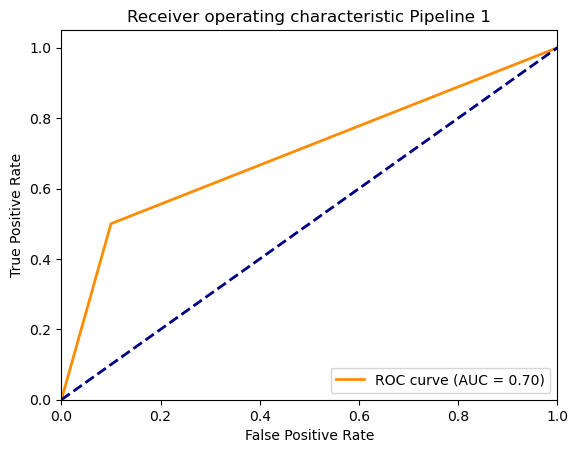

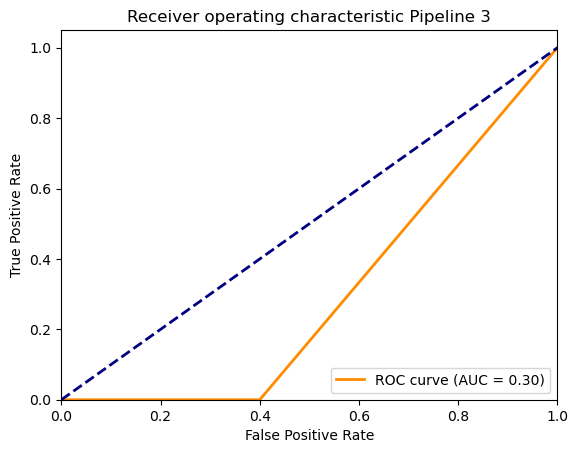

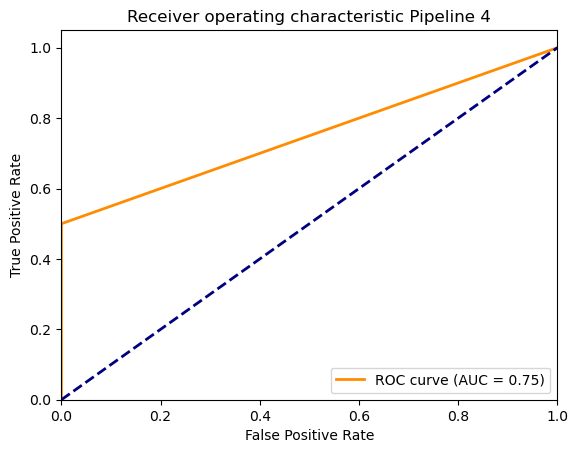

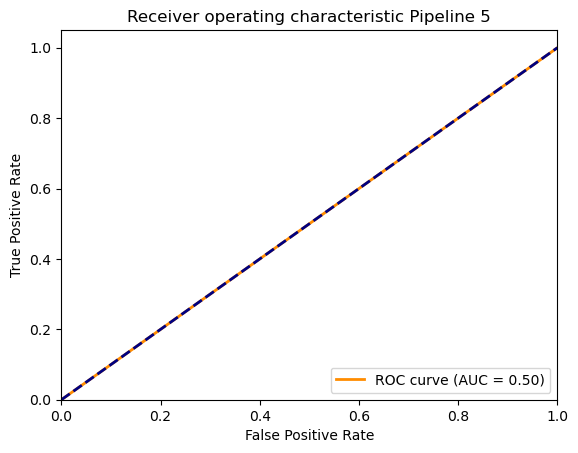

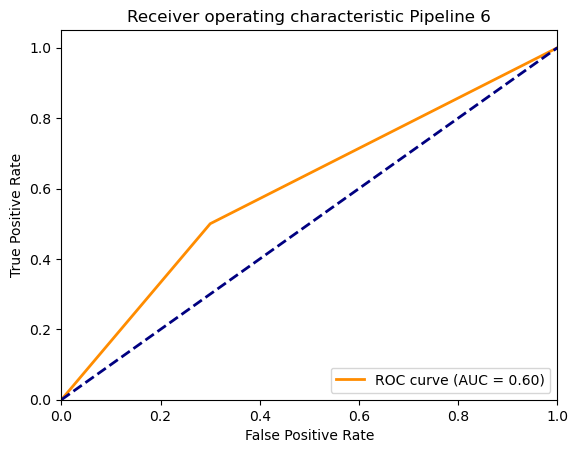

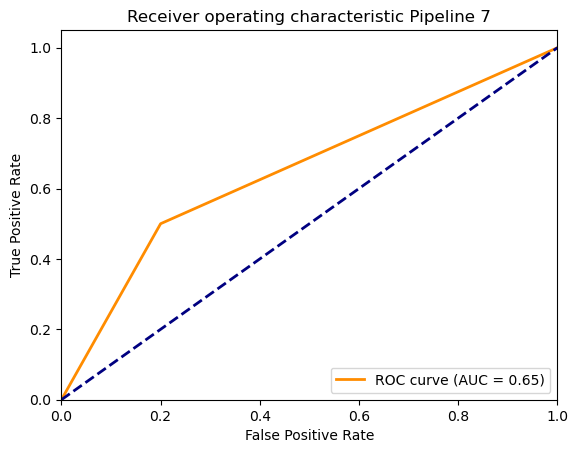

In [55]:
# Plot ROC-AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# y_test contains the true labels, y_pred contains the predicted scores
fpr1, tpr1, thresholds = roc_curve(y_test_1, y_pred_1)

# Calculate the area under the curve (AUC)
roc_auc_1 = auc(fpr1, tpr1)

# Plot the ROC curve
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 1')
plt.legend(loc="lower right")
plt.show()

# # y_test contains the true labels, y_pred contains the predicted scores
# fpr2, tpr2, thresholds = roc_curve(y_test_2, y_pred_2)

# # Calculate the area under the curve (AUC)
# roc_auc_2 = auc(fpr2, tpr2)

# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_2)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic Pipeline 2')
# plt.legend(loc="lower right")
# plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr3, tpr3, thresholds = roc_curve(y_test_3, y_pred_3)

# Calculate the area under the curve (AUC)
roc_auc_3 = auc(fpr3, tpr3)

# Plot the ROC curve
plt.figure()
plt.plot(fpr3, tpr3, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 3')
plt.legend(loc="lower right")
plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr4, tpr4, thresholds = roc_curve(y_test_4, y_pred_4)

# Calculate the area under the curve (AUC)
roc_auc_4 = auc(fpr4, tpr4)

# Plot the ROC curve
plt.figure()
plt.plot(fpr4, tpr4, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 4')
plt.legend(loc="lower right")
plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr5, tpr5, thresholds = roc_curve(y_test_5, y_pred_5)

# Calculate the area under the curve (AUC)
roc_auc_5 = auc(fpr5, tpr5)

# Plot the ROC curve
plt.figure()
plt.plot(fpr5, tpr5, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 5')
plt.legend(loc="lower right")
plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr6, tpr6, thresholds = roc_curve(y_test_6, y_pred_6)

# Calculate the area under the curve (AUC)
roc_auc_6 = auc(fpr6, tpr6)

# Plot the ROC curve
plt.figure()
plt.plot(fpr6, tpr6, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_6)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 6')
plt.legend(loc="lower right")
plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr7, tpr7, thresholds = roc_curve(y_test_7, y_pred_7)

# Calculate the area under the curve (AUC)
roc_auc_7 = auc(fpr7, tpr7)

# Plot the ROC curve
plt.figure()
plt.plot(fpr7, tpr7, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_7)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 7')
plt.legend(loc="lower right")
plt.show()

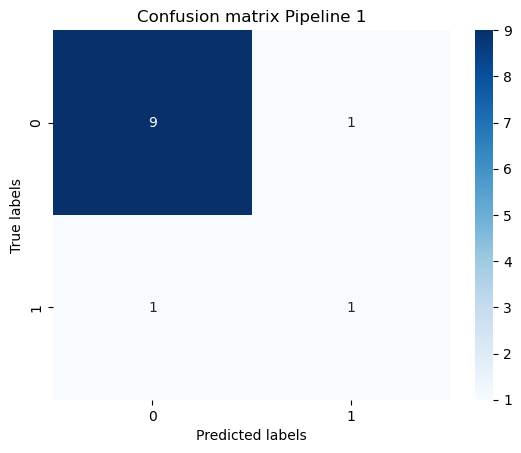

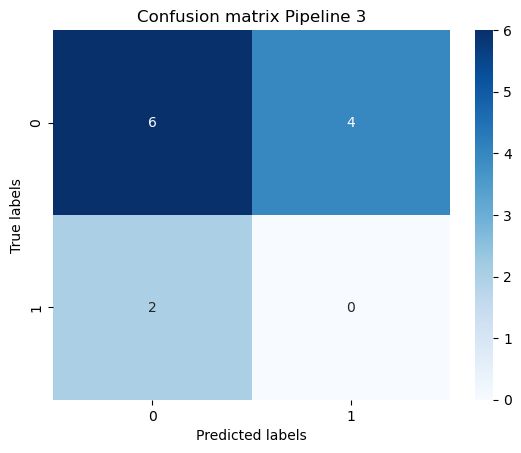

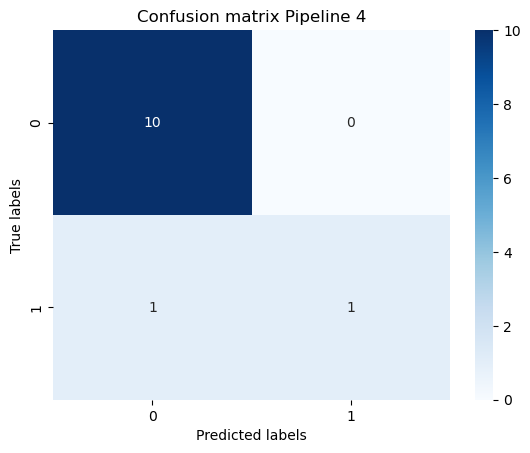

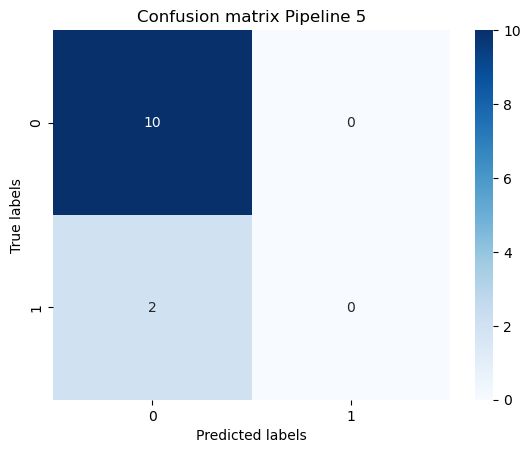

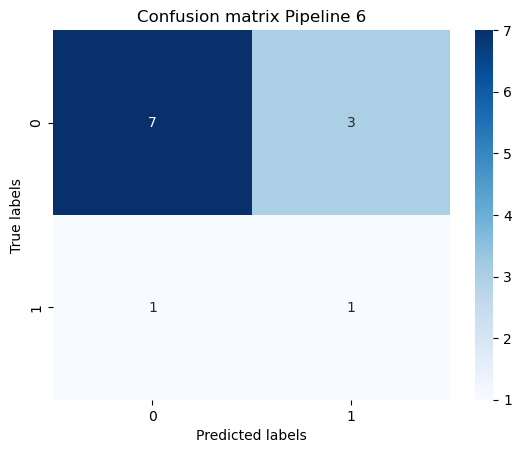

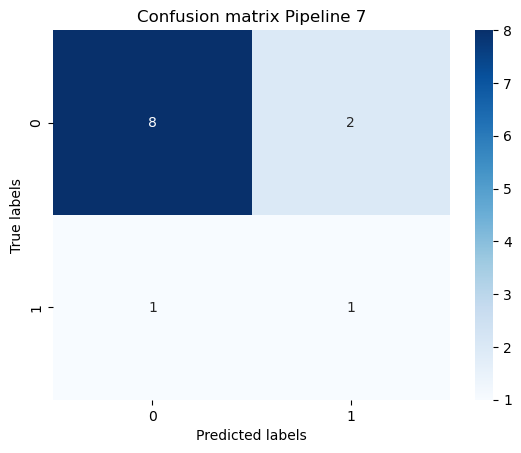

In [56]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# y_test contains the true labels, y_pred contains the predicted labels
cm1 = confusion_matrix(y_test_1, y_pred_1)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm1, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 1')
plt.show()

# # y_test contains the true labels, y_pred contains the predicted labels
# cm2 = confusion_matrix(y_test_2, y_pred_2)

# # Plot the confusion matrix as a heatmap
# sns.heatmap(cm2, annot=True, cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion matrix Pipeline 2')
# plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm3 = confusion_matrix(y_test_3, y_pred_3)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm3, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 3')
plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm4 = confusion_matrix(y_test_4, y_pred_4)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm4, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 4')
plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm5 = confusion_matrix(y_test_5, y_pred_5)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm5, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 5')
plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm6 = confusion_matrix(y_test_6, y_pred_6)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm6, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 6')
plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm7 = confusion_matrix(y_test_7, y_pred_7)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm7, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 7')
plt.show()

In [ ]:
# # Tabel hyperparameter chosen one
# # Tabel ROC-AUC
# from IPython.display import HTML

# # Hierboven hyperparameters van de gekozen invullen
# df = pd.DataFrame({'Hyperparameter 1': best_hp_1                   
# })

# # define a function to format the table
# def format_table(df):
#     return df.style.set_table_styles([{
#         'selector': 'th',
#         'props': [
#             ('font-size', '14pt'),
#             ('text-align', 'center'),
#             ('border', '1px solid #ddd'),
#             ('padding', '8px')
#         ]
#     }, {
#         'selector': 'td',
#         'props': [
#             ('font-size', '12pt'),
#             ('text-align', 'center'),
#             ('border', '1px solid #ddd'),
#             ('padding', '8px')
#         ]
#     }])

# # display the DataFrame as a table
# print('Table Hyperparameters')
# HTML(format_table(df).render())

## Meuk

In [ ]:
# Define the pipelines
#1
def pipeline1(X_train, y_train, X_test, y_test):
    # Preprocessing
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Variance Threshold
    vt = VarianceThreshold(threshold=0.0)
    X_train = vt.fit_transform(X_train)
    X_test = vt.transform(X_test)

    # PCA
    n_samples = X_train.shape[0]
    n_features = X_train.shape[1]
    n_features = min(n_samples, n_features)
    pca = PCA(n_components=n_features)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # Univariate selection
    kb = SelectKBest(f_classif, k='all') # juiste code erin als af
    X_train = kb.fit_transform(X_train, y_train)
    p_values_train = kb.pvalues_
    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values_train, alpha=0.05, method='fdr_bh')
    features_selected_train = np.array(np.where(reject_fdr)[0])
    print(features_selected_train.shape)
    X_train = X_train[:,features_selected_train]

    X_test = kb.transform(X_test)
    p_values_test = kb.pvalues_
    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values_test, alpha=0.05, method='fdr_bh')
    features_selected_test = np.array(np.where(reject_fdr)[0])
    print(features_selected_test.shape)
    X_test = X_test[:,features_selected_test]

    # KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    roc_auc_score = roc_auc_score(y_test, y_pred)

    return roc_auc_score

def pipeline2(X_train, y_train, X_test, y_test, alpha=0.5, n_neighbors=5):
    # Preprocessing
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Variance Threshold
    vt = VarianceThreshold(threshold=0.0)
    X_train = vt.fit_transform(X_train)
    X_test = vt.transform(X_test)

    # LASSO regularization
    lasso = Lasso(alpha=alpha)
    X_train = lasso.fit_transform(X_train, y_train)
    X_test = lasso.transform(X_test)

    # KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    roc_auc_score = roc_auc_score(y_test, y_pred)

    return roc_auc_score

# Define the parameters for grid search
param_grid1 = {
    'n_pca': [], #doesn't have parameters that need grid_search
    'k_features': [], #doesn't have parameters that need grid_search
    'n_neighbors': list(range(1, 26, 2))
}

param_grid2 = {
    'alpha': [np.logspace(-5, 1, 100)],
    'n_neighbors': list(range(1, 26, 2))
}

# Define the outer and inner cross-validation
outer_cv = StratifiedKFold(n_splits=4) #als we 4 splits doen, wordt de data in 25%/75% gesplit
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform the grid search using nested cross-validation
best_scores1 = []
best_scores2 = []

best_n_neighbors = []
results_1 = []
results_2 = []

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    print(X_train.shape)
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test = y[test_index]
    print(X_test.shape)

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
#     grid_search1 = GridSearchCV(estimator=pipeline1, param_grid=param_grid1, cv=inner_cv, scoring='roc_auc') #error logisch, want pipeline1 is een functie
#     grid_search1.fit(X_train, y_train)
#     best_scores1.append(grid_search1.best_score_)

#     grid_search2 = GridSearchCV(estimator=pipeline2, param_grid=param_grid2, cv=inner_cv, scoring='roc_auc')
#     grid_search2.fit(X_train, y_train)
#     best_scores2.append(grid_search2.best_score_)

# # Print the best scores and the average score for each pipeline
# print(best_scores1)
# print(best_scores2)

# # Get resulting classifier, pipeline 1
# best_1 = grid_search1.best_estimator_
# print(f'Best classifier: k={best_1.n_neighbors}')
# best_n_neighbors.append(best_1.n_neighbors)

# # Test the classifier on the test data, pipeline 1
# probabilities = best_1.predict_proba(X_test)
# scores_1 = probabilities[:, 1]

# # Get the auc, pipeline 1
# auc_1 = metrics.roc_auc_score(y_test, scores_1)
# results_1.append({
#     'auc': auc_1,
#     'k': best_1.n_neighbors,
#     'set': 'test'
# })

# # Create results dataframe and plot it, pipeline 1
# results = pd.DataFrame(results_1)
# seaborn.boxplot(y='auc', x='set', data=results_1)

# optimal_n = int(np.median(best_n_neighbors))
# print(f"The optimal N={optimal_n}")